# Data Prep

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.display import clear_output
!pip install --upgrade kaggle
clear_output()
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download -d sshikamaru/fruit-recognition

 88% 90.0M/102M [00:00<00:00, 98.3MB/s]
100% 102M/102M [00:01<00:00, 104MB/s]  


In [ ]:
!unzip '/content/fruit-recognition.zip';

In [5]:
full_classes = ['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado',
           'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry',
           'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon',
           'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit',
           'Peach','Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum','Pomegranate',
           'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']

classes = ['Apple Braeburn','Lemon', 'Orange', 'Pepper Green', 'Pomegranate', 'Tomato']
redundent_classes = [item for item in full_classes if item not in classes]

In [6]:
train_path = '/content/train/train/'
test_path = '/content/test/'

In [7]:
!rm -rf '/content/test/'

In [8]:
# !rm -rf '/content/test/'
# !rm -rf '/content/train/'

In [9]:
for Class in redundent_classes:
    shutil.rmtree("/content/train/train/" + Class)

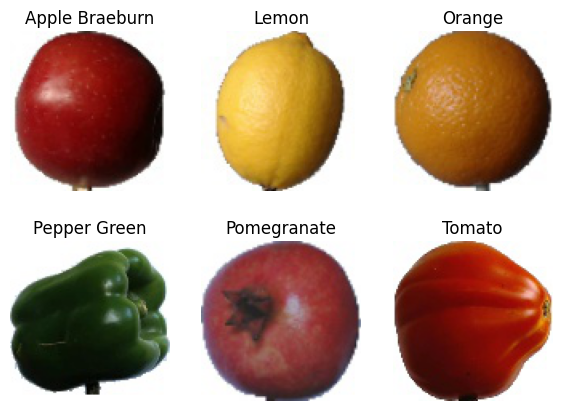

In [10]:
import matplotlib.image as mpimg
plt.figure(figsize = (7,5))

# View a random image from the training dataset for all classes
for i in range(6):
    plt.subplot(2,3,i+1)
    img = mpimg.imread(train_path + classes[i] + '/' + classes[i] +'_' + str(i)+ '.jpg')
    plt.imshow(img)
    plt.title(classes[i])
    plt.axis("off");

## seperating train & test folders

In [11]:
os.mkdir('/content/test/')
for i , Class in enumerate(classes):
  source = '/content/train/train/' + Class
  allfiles = os.listdir(source)
  os.mkdir('/content/test/' + Class)
  for i in range(len(allfiles)//3):
    src_path = os.path.join(source, allfiles[i])
    dst_path = os.path.join('/content/test/' + Class, allfiles[i])
    shutil.move(src_path, dst_path)

## duplicating training files

In [12]:
train_dir = '/content/train/train/'
for Class in classes:
  for i, pic in enumerate(os.listdir(train_dir + Class)):
    shutil.copy('/content/train/train/' + Class + '/'+pic, '/content/train/train/' + Class + '/1'+pic)
    shutil.copy('/content/train/train/' + Class + '/'+pic, '/content/train/train/' + Class + '/2'+pic)

## data augmentation an data loader

In [59]:
from torchvision import datasets, transforms
import random
SIZE = 16
train_transforms = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.Pad(padding = random.randint(0,3), fill = 1,padding_mode = 'edge'),
    transforms.Resize(size=(SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)

])
test_transforms = transforms.Compose([
    transforms.Resize(size=(SIZE,SIZE)),
    # transforms.CenterCrop(size =(30, 30) ),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)

])

In [60]:
import torch.utils.data as Data

train_data = datasets.ImageFolder(root=train_path, transform = train_transforms)
test_data = datasets.ImageFolder(root=test_path, transform = test_transforms)



In [61]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=2,
                             shuffle=True)
val_dataloader = DataLoader(dataset = test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=2,
                            shuffle=True)
print(f"The length of train_dataloader per batch is {len(train_dataloader)}")
print(f"The length of val_dataloader per batch is {len(val_dataloader)}")

The length of train_dataloader per batch is 99
The length of val_dataloader per batch is 17


In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## import pretrained model

In [70]:
model = torchvision.models.googlenet(pretrained=True)
model.fc=nn.Sequential(
    nn.Linear(in_features=1024,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=6,bias=True)
) 
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [71]:
from torchsummary import summary

print(summary(model, (3, 250, 250)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
       BatchNorm2d-2         [-1, 64, 125, 125]             128
       BasicConv2d-3         [-1, 64, 125, 125]               0
         MaxPool2d-4           [-1, 64, 62, 62]               0
            Conv2d-5           [-1, 64, 62, 62]           4,096
       BatchNorm2d-6           [-1, 64, 62, 62]             128
       BasicConv2d-7           [-1, 64, 62, 62]               0
            Conv2d-8          [-1, 192, 62, 62]         110,592
       BatchNorm2d-9          [-1, 192, 62, 62]             384
      BasicConv2d-10          [-1, 192, 62, 62]               0
        MaxPool2d-11          [-1, 192, 31, 31]               0
           Conv2d-12           [-1, 64, 31, 31]          12,288
      BatchNorm2d-13           [-1, 64, 31, 31]             128
      BasicConv2d-14           [-1, 64,

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(),
                           lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', cooldown = 2, factor = 0.9)

In [73]:
def train(model,dataloader,loss_fn,optimizer,device):
    model.train()
    train_loss = 0
    epoch_corrects = 0
    total_pics = 0
    for batch, (X,y) in enumerate(dataloader):
        X, y =X.to(device), y.to(device)
        
        y_preds = model.forward(X)
        loss = loss_fn(y_preds, y)
        train_loss += loss.item()
        batch_corrects = sum(y == y_preds.argmax(dim = 1))
        epoch_corrects += batch_corrects
        total_pics += len(y)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    train_loss = train_loss / len(dataloader)
    epoch_accuracy = epoch_corrects / total_pics
    return train_loss, epoch_accuracy

In [74]:
def val(model,dataloader,loss_fn,device):
    model.eval()
    epoch_corrects = 0
    val_loss = 0
    total_pics = 0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_logits = model.forward(X)
        
        loss = loss_fn(y_logits, y)
        val_loss += loss.item()
        batch_corrects = sum(y == y_logits.argmax(dim = 1))
        epoch_corrects += batch_corrects
        total_pics += len(y)
        
    val_loss = val_loss / len(dataloader)
    epoch_accuracy = epoch_corrects / total_pics
    return val_loss, epoch_accuracy

In [75]:
EPOCHS = 15

def train_and_val(model,train_dataloader,val_dataloader,loss_fn,optimizer,
                 epochs,device):
    results = {"train_loss": [],
              "val_loss": [],
               "train_acc": [],
              "val_acc": []}
    for epoch in range(epochs):
        train_loss, train_acc = train(model=model,dataloader=train_dataloader, loss_fn=loss_fn,
             optimizer=optimizer,device=device)
        
        val_loss, val_acc = val(model=model,dataloader=val_dataloader,
           loss_fn=loss_fn,device=device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1} of {EPOCHS} \n Train Loss:{train_loss:.3f} || Val Loss: {val_loss:.3f} || Train Accuracy:{train_acc:.3f} || Val Accuracy: {val_acc:.3f}")
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc.cpu().numpy())
        results['val_acc'].append(val_acc.cpu().numpy())
        
        
    return results

In [76]:
model_results = train_and_val(model=model,train_dataloader=train_dataloader,
                             val_dataloader=val_dataloader,loss_fn=loss_fn,
                             optimizer=optimizer,epochs=EPOCHS,device=device)

Epoch 1 of 15 
 Train Loss:0.886 || Val Loss: 0.091 || Train Accuracy:0.711 || Val Accuracy: 0.987
Epoch 2 of 15 
 Train Loss:0.060 || Val Loss: 0.009 || Train Accuracy:0.985 || Val Accuracy: 1.000
Epoch 3 of 15 
 Train Loss:0.056 || Val Loss: 0.004 || Train Accuracy:0.994 || Val Accuracy: 1.000
Epoch 4 of 15 
 Train Loss:0.047 || Val Loss: 0.006 || Train Accuracy:0.994 || Val Accuracy: 0.999
Epoch 5 of 15 
 Train Loss:0.041 || Val Loss: 0.003 || Train Accuracy:0.993 || Val Accuracy: 1.000
Epoch 6 of 15 
 Train Loss:0.036 || Val Loss: 0.005 || Train Accuracy:0.996 || Val Accuracy: 0.999
Epoch 7 of 15 
 Train Loss:0.027 || Val Loss: 0.007 || Train Accuracy:0.994 || Val Accuracy: 0.996
Epoch 8 of 15 
 Train Loss:0.047 || Val Loss: 0.020 || Train Accuracy:0.996 || Val Accuracy: 0.995
Epoch 9 of 15 
 Train Loss:0.038 || Val Loss: 0.004 || Train Accuracy:0.995 || Val Accuracy: 0.999
Epoch 10 of 15 
 Train Loss:0.032 || Val Loss: 0.007 || Train Accuracy:0.995 || Val Accuracy: 1.000
Epoch 11 

# results

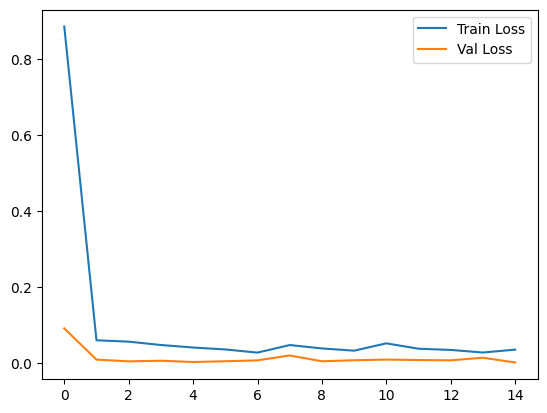

In [78]:
plt.plot(model_results['train_loss'])
plt.plot(model_results['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

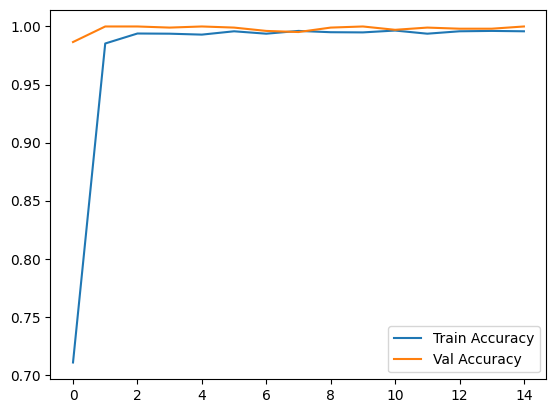

In [79]:
plt.plot(model_results['train_acc'])
plt.plot(model_results['val_acc'])
plt.legend(['Train Accuracy', 'Val Accuracy'])

In [80]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_dataloader:
        output = model(inputs.cuda()) # predict

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # save predict
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # save truth

In [81]:
from sklearn.metrics import f1_score, precision_score, accuracy_score
Accuracy  = accuracy_score(y_true, y_pred)
precision  = precision_score(y_true, y_pred, average='macro')
f1_Score = f1_score(y_true, y_pred, average='macro')
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')

Accuracy is 1.0
Presicion is 1.0
F1 score is 1.0


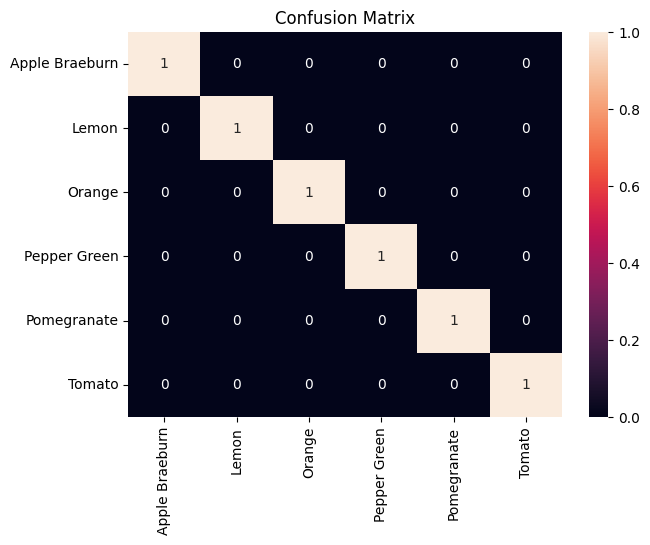

In [82]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix');